## Data Analytics Project

### Imports

In [1]:
import pickle
import re

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold
from imblearn.under_sampling import RandomUnderSampler
%matplotlib inline

In [2]:
seed=136
np.random.seed(seed)

### Read Data

1. Delete the NAs
2. We notice the huge imbalance within the dataset, so we need stratified resample
3. Randomly separate the train and test dataset with test size is 10% of all dataset

#### Solve Imbalance

In [3]:
reviews = pd.read_csv('Reviews.csv')
reviews = reviews[['Score', 'Summary', 'Text']]
reviews = reviews.dropna()
x = reviews[['Summary', 'Text']].values
y = reviews['Score'].values

model_RandomUnderSampler = RandomUnderSampler(sampling_strategy='all')
x_resampled, y_resampled = model_RandomUnderSampler.fit_sample(x,y)

#### Split data

In [4]:
train_d, test_d, train_l, test_l = train_test_split(x_resampled, y_resampled, test_size=0.1)
# train_d

### Text Preprocessing
1. Lowercase
2. No html sign
3. No number inside
4. Word tokenize
5. Lemma

In [5]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
wordnet_lemmatizer = WordNetLemmatizer()

def text_preprocessing(data):
    new_data = []
    for item in data:
        text = item.lower()
        striptext = text.replace('\n', ' ')
        no_html_text = re.sub("(<.*?>)","",striptext)
        no_num_text = re.sub('\d+', '', no_html_text)
        finaltext = re.sub("n't",' not', no_num_text)
        words = word_tokenize(finaltext)
        lemma_words = [wordnet_lemmatizer.lemmatize(word, pos='v') for word in words if word.isalpha()]
        sentence= ' '.join(lemma_words)
        new_data.append(sentence)
    return np.array(new_data)

In [6]:
new_train_d = text_preprocessing(train_d[:,0])
new_test_d = text_preprocessing(test_d[:,0])

### Features Engineering

Three kinds of Features to use for this model:
1. Count vector: count the number of each words in vocabulary for each review.
2. Set vector: use a set to reveal whether each words in vocabulary appear for each review.
3. Tfidf vector: use Tfidf features.Convert a collection of raw documents to a matrix of TF-IDF features.

In [7]:
countVectorizer=CountVectorizer(input="content")
train_count = countVectorizer.fit_transform(new_train_d)
test_count = countVectorizer.transform(new_test_d)

setVectorizer=CountVectorizer(binary=True, input="content")
train_set = setVectorizer.fit_transform(new_train_d)
test_set = setVectorizer.transform(new_test_d)

tfidfVectorizer = TfidfVectorizer(input="content")
train_Tfidf = tfidfVectorizer.fit_transform(new_train_d)
test_Tfidf = tfidfVectorizer.transform(new_test_d)

In [8]:
train_features = [train_count, train_set, train_Tfidf]
test_features = [test_count, test_set, test_Tfidf]

## Helper function

In [9]:
def plot_mse(predict, test_label):
    fig = plt.figure(figsize=(16, 10))
    mse = []
    for i in range(1,6):
        match = predict[np.where(test_label==i)]
        mse.append(np.mean((match-i)**2))
        match_count = np.unique(match, return_counts=True)
        ax = fig.add_subplot(230+i)
        ax.bar(match_count[0], match_count[1])
        ax.set_title('True score = '+str(i))
        ax.set_xlabel('Score')
        ax.set_ylabel('Counts')
    ax = fig.add_subplot(236)
    ax.plot(np.arange(1,6), mse)
    ax.set_title('MSE')
    ax.set_xlabel('Score')
    fig.show()

## MNB and CV to select features

Model: Multinomial Naive Bayes

Use cross-validation to select which features to use


In [10]:
import datetime as dt

def model_cross_validation(model,X,y,folds):
    kfolds=len(folds)
    train_performance=np.empty(kfolds)
    validation_performance=np.empty(kfolds)
    validation_MSE=np.empty(kfolds)
    for idx in range(kfolds):
        train,validation=folds[idx]
        X_train=X[train]
        y_train=y[train]
        model.fit(X_train,y_train)
        train_accuracy=np.mean(model.predict(X_train)==y_train)
        X_validation=X[validation]
        y_validation=y[validation]
        val_pred = model.predict(X_validation)
        validation_accuracy=np.mean(val_pred==y_validation)
        validation_mse = np.mean((val_pred-y_validation)**2)
        
        train_performance[idx] = train_accuracy
        validation_performance[idx] = validation_accuracy
        validation_MSE[idx] = validation_mse
    return train_performance, validation_performance, validation_MSE

In [11]:
kf = KFold(10,shuffle=True)
features_name = ['Count', 'Set', 'Tfidf']
results = []

train_accuracy = []; val_accuracy = []
model = MultinomialNB()
for i in range(3):
    feature = train_features[i]
    folds = list(kf.split(feature))
    t,v,_ = model_cross_validation(model, feature, train_l, folds)
    train_accuracy.append(t); val_accuracy.append(v)
    each_row = (features_name[i], t.mean(), v.mean())
    results.append(each_row)
feature_validation=pd.DataFrame(results,columns=["Features","training","validation"])
feature_validation

,Features,training,validation
0,Count,0.559505,0.504034
1,Set,0.559847,0.504288
2,Tfidf,0.564579,0.498939


### Fit the best features

In [12]:
X = train_features[np.argmax(feature_validation['validation'].values)]
X_test = test_features[np.argmax(feature_validation['validation'].values)]
kf = KFold(10,shuffle=True)
folds = list(kf.split(X))

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


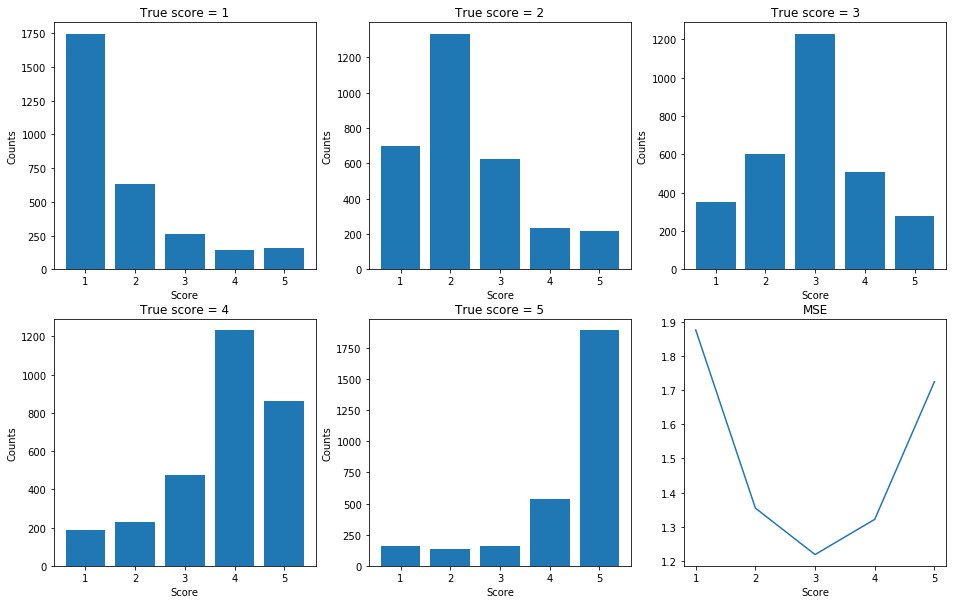

In [13]:
model = MultinomialNB()
MNB_train, MNB_val, MNB_val_mse = model_cross_validation(model,X,train_l,folds)

model = MultinomialNB()
model.fit(X, train_l)
predict_mnb = model.predict(X_test)

plot_mse(predict_mnb, test_l)

#### Logistics Regression -- one vs all

## Logistic Regression and CV to select penalty coef

Use cross-validation to select which C to use


#### Logistics Regression -- one vs all

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

train_accuracy = []; val_accuracy = []
results = []
C_list = [10**i for i in range(-4,4)]
for C in C_list:
    model= OneVsRestClassifier(LogisticRegression(C=C, penalty='l1', solver='liblinear'))
    t,v,_ = model_cross_validation(model, X, train_l, folds)
    train_accuracy.append(t); val_accuracy.append(v)
    each_row = (C, t.mean(), v.mean())
    results.append(each_row)
    
C_ova_validation = pd.DataFrame(results,columns=["C","training","validation"])
C_ova_validation

,C,training,validation
0,0.0001,0.200867,0.197336
1,0.0010,0.296792,0.296792
2,0.0100,0.415381,0.414806
3,0.1000,0.486493,0.477153
4,1.0000,0.568694,0.520994
5,10.0000,0.621510,0.523347
6,100.0000,0.622293,0.521315
7,1000.0000,0.622313,0.520262


#### Best LR -- one vs all

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


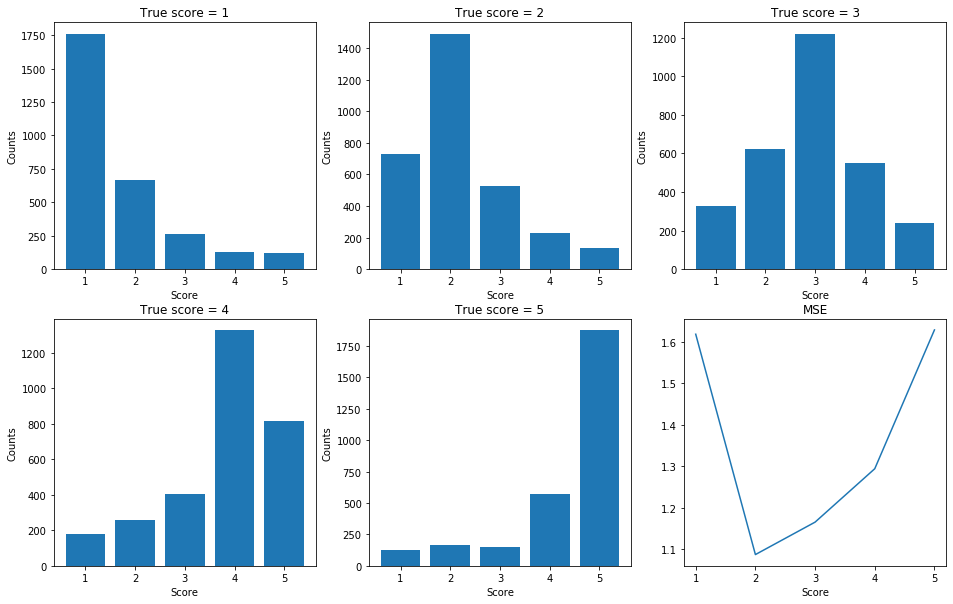

In [15]:
Best_C_ova = C_list[np.argmax(C_ova_validation['validation'].values)]
model= OneVsRestClassifier(LogisticRegression(penalty='l1',solver = 'liblinear', C=Best_C_ova))
lr_ova_train, lr_ova_val, lr_ova_mse = model_cross_validation(model,X,train_l,folds)

model= OneVsRestClassifier(LogisticRegression(penalty='l1',solver = 'liblinear', C=Best_C_ova))
model.fit(X, train_l)
predict_ova = model.predict(X_test)

plot_mse(predict_ova, test_l)

### Logistics Regression -- one vs one

In [16]:
from sklearn.multiclass import OneVsOneClassifier

train_accuracy = []; val_accuracy = []
results = []
C_list = [10**i for i in range(-4,4)]
for C in C_list:
    model= OneVsOneClassifier(LogisticRegression(C=C, penalty='l1', solver='liblinear'))
    t,v,_ = model_cross_validation(model, X, train_l, folds)
    train_accuracy.append(t); val_accuracy.append(v)
    each_row = (C, t.mean(), v.mean())
    results.append(each_row)

C_ovo_validation=pd.DataFrame(results,columns=["C","training","validation"])
C_ovo_validation

,C,training,validation
0,0.0001,0.200324,0.200324
1,0.0010,0.290395,0.290292
2,0.0100,0.403954,0.403293
3,0.1000,0.473637,0.465999
4,1.0000,0.564406,0.517654
5,10.0000,0.636369,0.529347
6,100.0000,0.637456,0.526052
7,1000.0000,0.637352,0.524744


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


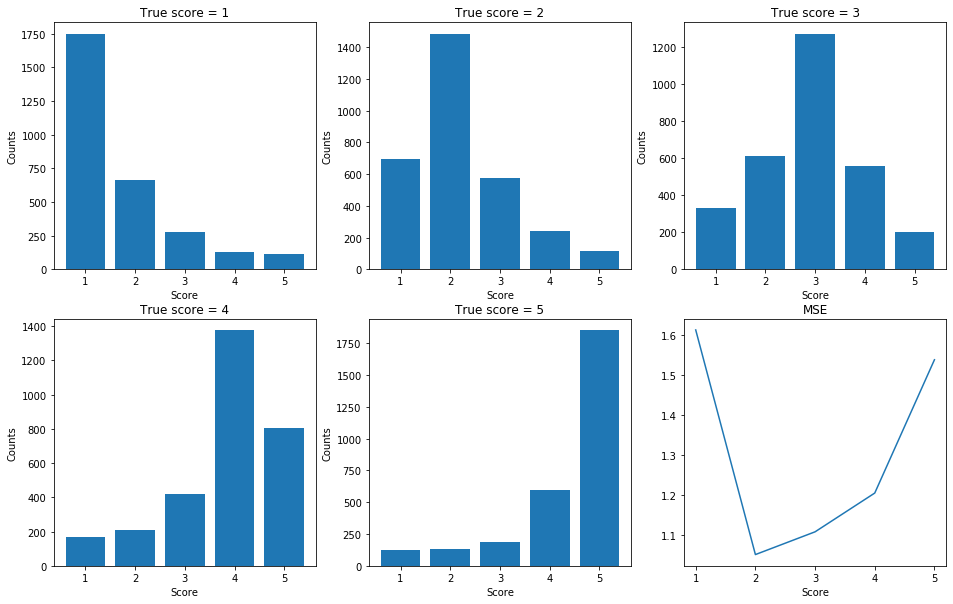

In [17]:
Best_C_ovo = C_list[np.argmax(C_ovo_validation['validation'].values)]
model= OneVsOneClassifier(LogisticRegression(penalty='l1',solver = 'liblinear', C=Best_C_ovo))
lr_ovo_train, lr_ovo_val, lr_ovo_mse = model_cross_validation(model,X,train_l,folds)

model= OneVsOneClassifier(LogisticRegression(penalty='l1',solver = 'liblinear', C=Best_C_ovo))
model.fit(X, train_l)
predict_ovo = model.predict(X_test)

plot_mse(predict_ovo, test_l)

## Mord
Really take hours to run it!
### Logistic IT

In [18]:
import mord
import datetime as dt

train_accuracy = []; val_accuracy = []
results = []
C_list = [10**i for i in range(-4,2)]
for C in C_list:
    start = dt.datetime.now()
    model= mord.LogisticIT(alpha=C)
    t,v,_= model_cross_validation(model, X, train_l, folds)
    train_accuracy.append(t); val_accuracy.append(v)
    each_row = (C, t.mean(), v.mean())
    results.append(each_row)
    end = dt.datetime.now()
    print('C:', C, 'Time:', (end-start).total_seconds())
    
mord_IT_validation=pd.DataFrame(results,columns=["C","training","validation"])
mord_IT_validation

C: 0.0001 Time: 1160.522503
C: 0.001 Time: 1158.404734
C: 0.01 Time: 1159.955284
C: 0.1 Time: 1159.854996
C: 1 Time: 926.193987
C: 10 Time: 330.737892


,C,training,validation
0,0.0001,0.520806,0.460171
1,0.0010,0.520747,0.460216
2,0.0100,0.520473,0.460410
3,0.1000,0.516993,0.459551
4,1.0000,0.483387,0.451505
5,10.0000,0.441431,0.430593


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


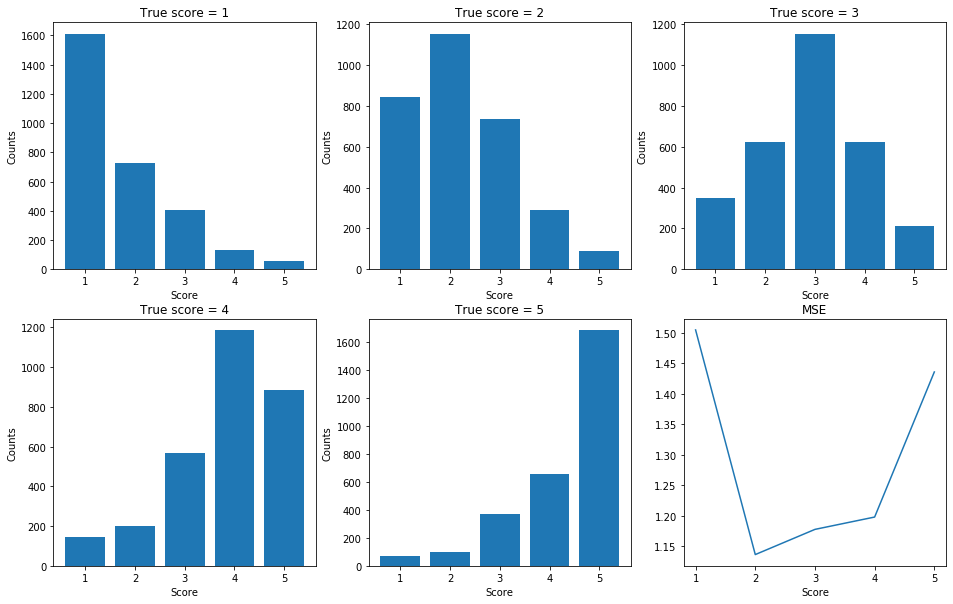

In [19]:
Best_IT = C_list[np.argmax(mord_IT_validation['validation'].values)]
model= mord.LogisticIT(alpha=Best_IT)
IT_train, IT_val, IT_mse = model_cross_validation(model,X,train_l,folds)

model= mord.LogisticIT(alpha=Best_IT)
model.fit(X, train_l)
predict_it = model.predict(X_test)

plot_mse(predict_it, test_l)

### Logistic AT

In [20]:
train_accuracy = []; val_accuracy = []
results = []
C_list = [10**i for i in range(-4,2)]
for C in C_list:
    start = dt.datetime.now()
    model= mord.LogisticAT(alpha=C)
    t,v,_= model_cross_validation(model, X, train_l, folds)
    train_accuracy.append(t); val_accuracy.append(v)
    each_row = (C, t.mean(), v.mean())
    results.append(each_row)
    end = dt.datetime.now()
    print('C:', C, 'Time:', (end-start).total_seconds())
    
mord_AT_validation=pd.DataFrame(results,columns=["C","training","validation"])
mord_AT_validation

C: 0.0001 Time: 1155.30454
C: 0.001 Time: 1156.117678
C: 0.01 Time: 1150.6122
C: 0.1 Time: 1152.097013
C: 1 Time: 1093.577029
C: 10 Time: 407.04708


,C,training,validation
0,0.0001,0.506578,0.447986
1,0.0010,0.506640,0.448105
2,0.0100,0.506623,0.448165
3,0.1000,0.505842,0.448666
4,1.0000,0.471992,0.441852
5,10.0000,0.433602,0.423032


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


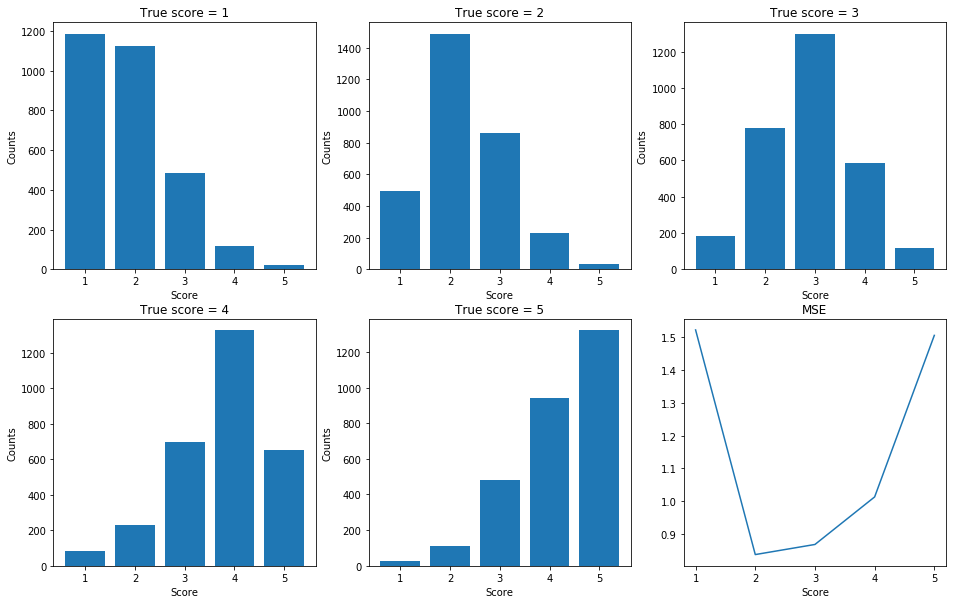

In [21]:
Best_AT = C_list[np.argmax(mord_AT_validation['validation'].values)]
model= mord.LogisticAT(alpha=Best_AT)
AT_train, AT_val, AT_mse = model_cross_validation(model,X,train_l,folds)

model= mord.LogisticAT(alpha=Best_AT)
model.fit(X, train_l)
predict_at = model.predict(X_test)

plot_mse(predict_at, test_l)

## Vader Baseline

write a function vader_analysis():

INPUT:
texts: after lemma!

OUPUT:
ndarray: scores of this texts(1 to 5)

In [22]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def vader_analysis(documents):
    analyzer = SentimentIntensityAnalyzer()
    result =[]
    for sentence in documents:
        vs = analyzer.polarity_scores(sentence)
        result.append(vs['compound'])
    result = np.floor((np.array(result)+1) * 5/2) + 1
    return result.astype(int)

In [23]:
vs_result = vader_analysis(new_train_d)
vs_result_raw = vader_analysis(train_d[:,0])
vs_acc = np.mean(vs_result==train_l)
vs_acc_raw = np.mean(vs_result_raw==train_l)
print('Acc:', vs_acc)
print('Raw Acc:', vs_acc_raw)

Acc: 0.31505887275118044
Raw Acc: 0.3224702647779571


## LSTM

In [24]:
import tensorflow_datasets as tfds

tokenizer = tfds.features.text.Tokenizer()
vocabulary_set = set()
for text_tensor in np.append(new_train_d, new_test_d):
    some_tokens = tokenizer.tokenize(text_tensor)
    vocabulary_set.update(some_tokens)
vocab_size = len(vocabulary_set)

encoder = tfds.features.text.TokenTextEncoder(vocabulary_set)
train_data = tf.data.Dataset.from_tensor_slices((new_train_d, (train_l-1)))
test_data = tf.data.Dataset.from_tensor_slices((new_test_d, (test_l-1)))

In [25]:
def encode(text_tensor, label):
    encoded_text = encoder.encode(text_tensor.numpy())
    return encoded_text, label
def encode_map_fn(text, label):
    return tf.py_function(encode, inp=[text, label], Tout=(tf.int64, tf.int64))

map_train_data = train_data.map(encode_map_fn)
map_test_data = test_data.map(encode_map_fn)

BATCH_SIZE = 64
batch_train_data = map_train_data.padded_batch(BATCH_SIZE, padded_shapes=([-1],[]))
batch_test_data = map_test_data.padded_batch(BATCH_SIZE, padded_shapes=([-1],[]))
vocab_size += 1

In [26]:
def build_model(vocab_size):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size, 64))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(5, activation='softmax'))
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

model = build_model(vocab_size)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          987584    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 1,062,213
Trainable params: 1,062,213
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.fit(batch_train_data, epochs=10, validation_data=batch_test_data, verbose=2)

Epoch 1/10
2092/2092 - 104s - loss: 1.1836 - accuracy: 0.4862 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
2092/2092 - 96s - loss: 1.0452 - accuracy: 0.5593 - val_loss: 1.0986 - val_accuracy: 0.5314
Epoch 3/10
2092/2092 - 96s - loss: 0.9658 - accuracy: 0.6004 - val_loss: 1.0973 - val_accuracy: 0.5426
Epoch 4/10
2092/2092 - 96s - loss: 0.9024 - accuracy: 0.6287 - val_loss: 1.1167 - val_accuracy: 0.5448
Epoch 5/10
2092/2092 - 97s - loss: 0.8494 - accuracy: 0.6500 - val_loss: 1.1548 - val_accuracy: 0.5507
Epoch 6/10
2092/2092 - 97s - loss: 0.8040 - accuracy: 0.6681 - val_loss: 1.2060 - val_accuracy: 0.5504
Epoch 7/10
2092/2092 - 97s - loss: 0.7645 - accuracy: 0.6839 - val_loss: 1.2671 - val_accuracy: 0.5526
Epoch 8/10
2092/2092 - 96s - loss: 0.7287 - accuracy: 0.6983 - val_loss: 1.3325 - val_accuracy: 0.5582
Epoch 9/10
2092/2092 - 96s - loss: 0.6964 - accuracy: 0.7109 - val_loss: 1.3919 - val_accuracy: 0.5644
Epoch 10/10
2092/2092 - 97s - loss: 0.6660 - accuracy: 0.7239 - 

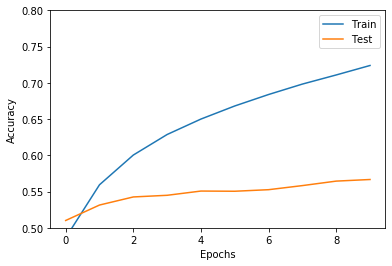

In [28]:
plt.plot(model.history.history['accuracy'], label='Train')
plt.plot(model.history.history['val_accuracy'], label='Test')
plt.ylim(0.5,0.8)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
pred_test = model.predict(batch_test_data)
pred_test_trans = np.argmax(pred_test,axis=1) + 1
lstm_acc = np.mean(pred_test_trans == test_l)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


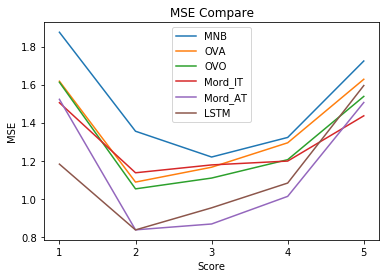

In [30]:
def plot_mse_compare(predicts, names, test_label):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i in range(len(predicts)):
        predict = predicts[i]
        name = names[i]
        mse = []
        for k in range(1,6):
            match = predict[np.where(test_label==k)]
            mse.append(np.mean((match-k)**2))
        ax.plot(np.arange(1,6), mse, label=name)
    ax.set_ylabel('MSE')
    ax.set_xlabel('Score')
    ax.set_title('MSE Compare')
    ax.legend()
    ax.set_xticks([1,2,3,4,5])
    fig.show()
        
predicts = [predict_mnb, predict_ova, predict_ovo, predict_it, predict_at, pred_test_trans]
names = ['MNB', 'OVA', 'OVO', 'Mord_IT', 'Mord_AT', 'LSTM']
plot_mse_compare(predicts, names, test_l)

## Boxplot of Different Models


In [31]:
model_names = ['MNB', 'Logit_OVA', 'Logit_OVO', 'Mord_IT', 'Mord_AT']
val_performance = pd.DataFrame([MNB_val, lr_ova_val, lr_ovo_val, IT_val, AT_val]).T
val_performance.columns = model_names
val_mse = pd.DataFrame([MNB_val_mse, lr_ova_mse, lr_ovo_mse, IT_mse, AT_mse]).T
val_mse.columns = model_names

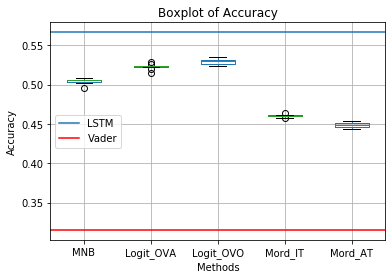

In [32]:
ax = val_performance.boxplot()
ax.axhline(y=lstm_acc,label='LSTM')
ax.axhline(y=vs_acc,label='Vader',color='red')
ax.set_title('Boxplot of Accuracy')
ax.set_xlabel('Methods')
ax.set_ylabel('Accuracy')
ax.legend()

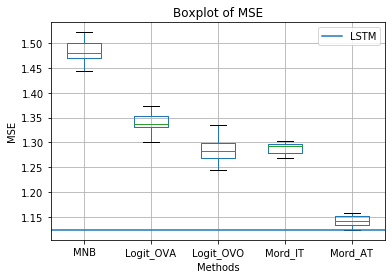

In [33]:
ax = val_mse.boxplot()
ax.axhline(y=np.mean((pred_test_trans - test_l)**2), label='LSTM')
ax.set_title('Boxplot of MSE')
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.legend()

In [34]:
from wordcloud import WordCloud, STOPWORDS

def selected_wordcloud(dataset, model_predict, test_label, pred=None, act=None):
    def get_wordcloud(paragraph):
        wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',width=3000,height=3000)
        graph = wordcloud.generate(paragraph)
        plt.imshow(wordcloud)
        plt.axis('off')
        plt.show()
        
    
    if pred is not None:
        if act is not None:
            selected = dataset[np.where((model_predict == pred) & (test_label==act))]
        else:
            selected = dataset[np.where(model_predict==pred)]
    else:
        if act is not None:
            selected = dataset[np.where(test_label==act)]
        else:
            selected = dataset[:]
        
    paragraph = ' '.join(selected)
    get_wordcloud(paragraph)
    return selected

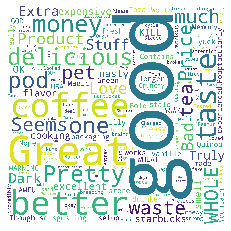

array(['What a disgusting waste of packaging',
       'not as good as the pet store?', 'Seems stale', 'Delicious!',
       'GOD AWFUL', 'delicious tea', 'No longer made in USA',
       'Total waste of money', 'Not much vanille taste', 'yuck',
       'fresh and good', 'WARNING - Contains Quinoa and WHOLE WHEAT',
       'Price is good but....', 'Pretty good', 'Worth the Price',
       'Great Product, easy to setup and it just works.',
       'Pooptacularly Bad', 'Thoughts from an experienced illy drinker',
       'Love this Stuff', 'Great coffee for the money',
       'I really like this one!', 'Nope',
       'Green Mountain Extra Bold Dark Magic...',
       'Memory was better than reality',
       'Crunchy is much better than chewy.',
       'Truly Disappointing. Product Changed. Not for the better!',
       'No happy with this salt server',
       'Tested these on the whole family',
       'Seems like the dark but more expensive.', 'Pretty Darn Good',
       'Thin and Weak',
       'Fr

In [35]:
selected_wordcloud(train_d[:,0], model_predict=pred_test_trans, test_label=test_l, pred=5, act=1)